# Initialize the accelerator

In [1]:
from finn_examples import models
print(list(filter(lambda x: "imagenet" in x, dir(models))))

['_imagenet_resnet50_top5inds_io_shape_dict', '_imagenet_top5inds_io_shape_dict', 'mobilenetv1_w4a4_imagenet', 'resnet50_w1a2_imagenet']


In [2]:
#mobilenetv1_w4a4 is available on U250 and ZCU104
accel = models.mobilenetv1_w4a4_imagenet()
#resnet50_w1a2 is available on U250 only
# accel = models.resnet50_w1a2_imagenet()
#some systems with custom builds might require a manual platform setting:
#accel = models.mobilenetv1_w4a4_imagenet("ZCU102")

In [3]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal), str(accel.idt)))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal), str(accel.odt)))

Expected input shape and datatype: (1, 224, 224, 3) DataType.UINT8
Expected output shape and datatype: (1, 1, 1, 5) DataType.UINT16


# Prepare loading of ImageNet validation dataset

In [4]:
import numpy as np
from PIL import Image
from dataset_loading import FileQueue, ImgQueue
import os

# 2 ways to provide the data:
# without a label file: expect images in 1000 sorted subfolders
# with a label file: expect images directly in val directory
val_dir = os.environ["IMAGENET_VAL_PATH"]
label_file = None
print(val_dir)

/dataset/imagenet/ILSVRC2012/images/validation


In [5]:
def img_resize(img, size):
    w, h = img.size
    if (w <= h and w == size) or (h <= w and h == size):
        return img
    if w < h:
        ow = size
        oh = int(size * h / w)
        return img.resize((ow, oh), Image.BILINEAR)
    else:
        oh = size
        ow = int(size * w / h)
        return img.resize((ow, oh), Image.BILINEAR)

def img_center_crop(img, size):
    crop_height, crop_width = (size, size)
    image_width, image_height = img.size
    crop_top = int(round((image_height - crop_height) / 2.))
    crop_left = int(round((image_width - crop_width) / 2.))
    return img.crop((crop_left, crop_top, crop_left + crop_width, crop_top + crop_height))

def pre_process(img_np):
    img = Image.fromarray(img_np.astype(np.uint8))
    img = img_resize(img, 256)
    img = img_center_crop(img, 224)
    img = np.array(img, dtype=np.uint8)
    return img

def setup_dataloader(val_path, label_file_path = None, batch_size=100, n_images = 50000):
    if label_file_path is None:
        val_folders = [ f.name for f in os.scandir(val_path) if f.is_dir() ]
        assert len(val_folders) == 1000, "Expected 1000 subfolders in ILSVRC2012 val"
        files = []
        labels = []
        for idx, folder in enumerate(val_folders):
            current_files = sorted(os.listdir(os.path.join(val_path, folder)))
            current_files = [os.path.join(folder, file) for file in current_files]
            files.extend(current_files)
            labels.extend([idx]*len(current_files))
        files = files[:n_images]
    else:
        files = ['ILSVRC2012_val_{:08d}.JPEG'.format(i) for i in range(1,n_images+1)]
        labels = np.loadtxt(label_file_path, dtype=int, usecols=1)

    file_queue = FileQueue()
    file_queue.load_epochs(list(zip(files,labels)), shuffle=False)
    img_queue = ImgQueue(maxsize=batch_size)
    img_queue.start_loaders(file_queue, num_threads=4, img_dir=val_path, transform=pre_process)
    return img_queue

# Classify a single image

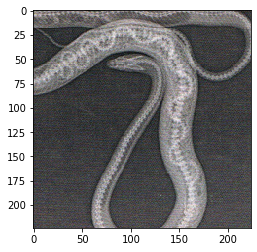

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

img_queue = setup_dataloader(val_dir, label_file, 1, 1)

test_single_x, test_single_y = img_queue.get()

plt.imshow(test_single_x)
plt.show()

In [7]:
test_single_y

0

In [8]:
accel_in = test_single_x.reshape(accel.ishape_normal)
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 224, 224, 3) and datatype is uint8


In [9]:
accel_out = accel.execute(accel_in)

In [10]:
print("Top-5 classes predicted by the accelerator: " + str(accel_out))

Top-5 classes predicted by the accelerator: [[[[ 60. 111.  65.  68.  66.]]]]


In [11]:
%%timeit
accel_out = accel.execute(accel_in)

2.86 ms ± 44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Validate accuracy on entire ImageNet validation set

In [12]:
batch_size = 100
accel.batch_size = batch_size
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed), str(accel.oshape_packed)) )

Accelerator buffer shapes are (100, 224, 224, 1, 3) for input, (100, 1, 1, 1, 10) for output


In [13]:
img_queue = setup_dataloader(val_dir, label_file, batch_size)

ok = 0
nok = 0
i = 0
while not img_queue.last_batch:
    imgs, lbls = img_queue.get_batch(batch_size, timeout=None)
    imgs = np.array(imgs)
    exp = np.array(lbls)
    
    ibuf_normal = imgs.reshape(accel.ishape_normal)
    obuf_normal = accel.execute(ibuf_normal)
    obuf_normal = obuf_normal.reshape(batch_size, -1)[:,0]
    print(obuf_normal)
    print(lbls)
    ret = np.bincount(obuf_normal.flatten() == exp.flatten())
    nok += ret[0]
    ok += ret[1]
    i += 1
    print("batch %d : total OK %d NOK %d" % (i, ok, nok))

[ 68.  38.  60.  66.  68.  66.  66.  66.  68.  54.  67.  67.  66.  66.
  68.  66.  66.  68.  68.  54.  66.  68.  60.  66.  54.  68.  68.  66.
  66.  68.  68.  66.  54.  68.  66. 971. 574.  68.  68.  58.  66.  39.
  68.  67. 363.  68.  66.  66.  67.  66.  36. 150. 150. 150. 150. 150.
 150. 337. 150. 150. 150. 150. 150. 150. 150.  33. 150. 976. 150. 150.
 150. 150. 150. 801. 150. 150. 150. 801. 150. 150. 150. 150. 150. 150.
 150. 460. 150. 524. 150. 150. 150. 150. 150. 976. 360. 150. 150. 344.
 150. 150.]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
total = 50000
acc = 100.0 * ok / (total)
print("Final top-1 accuracy: {}%".format(acc))

## More benchmarking

In [ ]:
accel.throughput_test()